# Building Autograd from Scratch in Swift
This notebook offers a guided tour that attempts to explain Swift for TensorFlow's implementation of automatic differentiation. 

But what, exactly, is [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)? It's nothing more than a software compiler having the ability to calculate the derivative of a numerical function that was written in the compiler's programming language. If you've ever written a neural network in PyTorch or TensorFlow, you know that although your code actually only explicitly outlines the architecture and layer order of a forward pass through the network, PyTorch/TensorFlow are nevertheless able to know how to calculate all layers' gradients during the backward pass in order to update weight values during training. This is possible because both the PyTorch and TensorFlow teams have worked hard to build auto-diff into their frameworks. 

However, in both PyTorch and TensorFlow auto-diff is happening deeper down inside some C++ code for which their Python front-ends merely serve as wrappers. This means that the Python debugger will be unable to give any kind of insight into the mechanics of *how* PyTorch or TensorFlow auto-diff is actually responding to the user's model architecture.

And this leads us to one of the key reasons that Swift for TensorFlow is interesting: the framework's contributors are turning Swift into a differentiable language. The benefit for practitioners is that the programming language they use to define their neural networks (Swift) is also the language of the compiler that figures out how to calculate gradients for all of a model's layers.

This will conceivably prevent the occurrence of those inscrutable run-time errors that seem to crop-up towards the end of training at only the most inopportune times, and with which Python-based framework practitioners and students are all too familiar. These errors are oftentimes caused by simple mistakes, such as a custom loss function that doesn't correctly anticipate the shape of tensors that will be passed to it under certain conditions. Using a language whose compiler understands autodiff means that the compiler can catch these errors prior to run-time. Though the Python compiler has no idea how the underlying C++ library performs autodiff, the Swift compiler would know exactly what's going on and would thus be able to warn the pracitioner *before* they embark on an ultimately doomed training run!

Swift for TensorFlow team member [Richard Wei](https://twitter.com/rxwei) previously [tweeted](https://twitter.com/rxwei/status/1142201106191142912) the following depiction of a prototype that hints at what the experience of using a compiler that can understand differentiation might look like. He describes it as being possible able to "*step over your code backwards using LLDB during backpropagation*."
<img src="images/s4tf_autodiff.gif" width="450">

The remainder of this notebook attempts to explain auto-differentiation in Swift by slowly building up the reader's understanding. We start out with the most simple toy examples imaginable, and steadily work our way up to advanced concepts.

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/swift/02c_autodiff.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [1]:
import Foundation
import Python

public let np = Python.import("numpy")
public let plt = Python.import("matplotlib.pyplot")

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

public let mpl = Python.import("matplotlib")
mpl.rcParams["figure.dpi"] = 120 // Set the DPI of plots to be a little higher than default.

## 1. Beginning with a Toy Example
Let's start off by simply reviewing what a derivative is. Say we have the equation $y = x^{2}$:

In [2]:
func plotEQ(_ fx: (Double) -> Double, _ y: [Double], _ title: String) {
    let x = y.map( fx ).makeNumpyArray() 
    plt.figure(figsize: [6,4])
    let fig = plt.plot(y, x)
    plt.title(title)
    plt.show(fig);
}

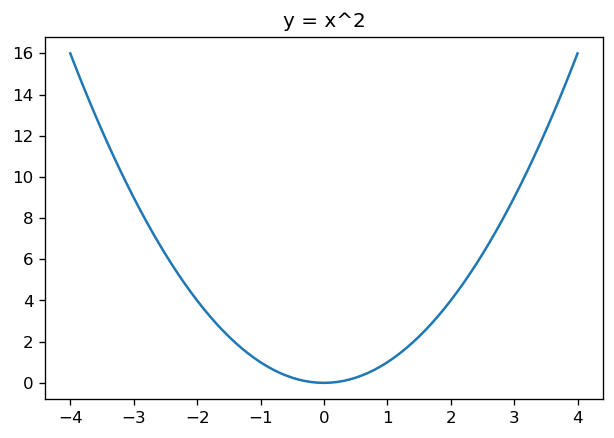

In [3]:
var y: ([Double]) = [-4.0]
for _ in (0..<80) { y.append(y.last! + 0.1) } // Make a list of y values in [-4.0, 4.0]
plotEQ({ pow($0, 2) }, y, "y = x^2") // And then square them

The derivative of this equation, $\frac{d}{dx} x^2$, is $2x$. 

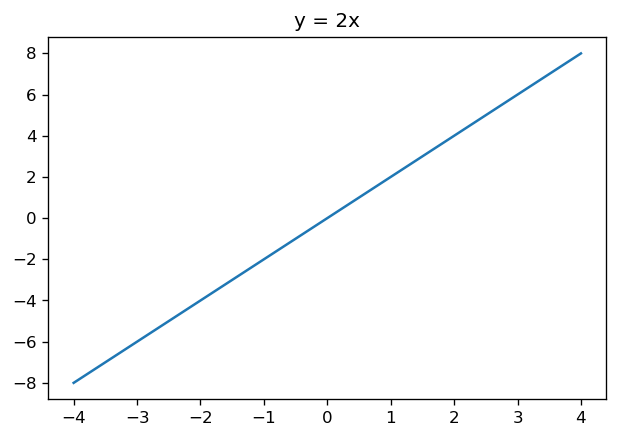

In [4]:
plotEQ({ $0 * 2 }, y, "y = 2x")

All the above derivative does is tell us: for any location, $x$, how rapidly the output value, $y$, is changing. So at the bottom of the graph of $y=x^2$, where $x$ values are near 0, the rate of change is almost imperceptible. The further we move away from 0, in either the positive or negative direction, the greater the rate of change. 

Another way of looking at this is that the derivative tells us the slope of $y=x^2$ at any point $x$. Imagine the slope as being a line that just touches $y=x^2$ at only the point $x$, and never intersects the graph of $y=x^2$ at any other location.

Calculating derivatives is probably *the* core mathematical operation performed when training a neural network. Our loss function will tell us "how far off" our model's predictions on the training set are after the end of a given epoch. In order to figure out how to adjust model's parameter weights so that on the next training epoch our predictions will be closer to the ground truth, we calculate the derivative of the loss function with respect to each of the model's final layer weights. This tells us the direction with respect to changes in each of these weights, that the output of the loss function is decreasing most rapidly. We then figure out how much the weights at each of the model's other layers contributed to the just-calculated training loss (also known as performing "backpropagation"). And then, just before we commence training of the next epoch, we adjust each of the model's weights, ever-so-slightly in the direction (either positive or negative) in which each a change in each weight leads to the steepest decrease in loss.

The moral of the story is that how differentiation is performed matters very much to deep learning libraries. Since derivatives are calculated every epoch whenever any model is trained, it's reasonable for the creators of deep learning libraries to devote much time and care to ensuring that their library calculates derivatives as efficiently as possible.

Returning to the example using the equation $y=x^2$, here's how both that equation and its derivative, $y=2x$, are represented in Swift code:

In [5]:
func square(_ x: Float) -> Float {
    return x * x
}

func squareDerivative(_ x: Float) -> Float {
    return 2 * x
}

## 2. Derivatives of more complicated functions
I metioned above that in order to adjust the weights of neural networks we not only need find out how much the final layer's weights affected loss, but need to find this out for all layers' weights. Thankfully, since the output of each neural network layer serves as the subsequent layer's inputs, the final layer outputs are nothing more than a function of the previous layer's outputs, which themselves are a function of the next previous layer's outputs, so on and so forth all the way back to the outputs of the first layer. 

In other words, neural network outputs are nothing more than a function-of-a-function-of-a-function-of... well, you get the idea -- they're just the result of a highly nested function. And in order to be able to calculate the derivatives necessary to update model layer weights, we're going to need to know how to calculate the derivative of a nested function. Thankfully again, if you've ever taken a first year calculus class, you'll know that the way to do this is to apply the chain rule.

A simple example of a nested function is $f\left(g(x)\right)$.

And if we use the chain rule to take it's derivative, the result would be:

$$\frac{d}{dx}\left[f\left(g(x)\right)\right] = f'\left(g(x)\right)g'(x)$$

An concrete example of a nested function is $\sin(x^2)$, and using the chain rule its derivative is:

$$\cos(x^2) * 2x$$

Here's how this function and its derivative are represented in code:

In [6]:
func nestedSine(_ x: Float) -> Float {
    return sin(x * x)
}

func nestedSineDerivative(_ x: Float) -> Float {
    return 2 * x * cos(x * x)
}

## 3. Making things more efficient
Notice that in each of the two functions above we calculated `x * x`, even though we conceivably already had its result after calcuating `nestedSineFunc` and shouldn't have needed to do it again to do `nestedSineFuncDerivative`. Imagine that the ultimate goal here is to have an algorithm remember the values of all functions used to compute a network's forward pass after the forward pass has been completed. 

Is there a way we could preserve this "forward pass" knowledge for when we want to calculate the derivative? The obvious benefit is that we wouldn't have to perform redundant operations. And since derivatives are performed repeatedly and over high dimensionsional space when training a neural network, reducing the amount of redundant operations is always good practice.

We actually can achieve this if we combine the two functions above into one single function that will calculate $x^2$ just once and use this result to formulate and return two closures. The first closure returns the value of $\sin(x^2)$ and the second closure will return its derivative. And both make use of the same calculation of `x * x`:

In [7]:
func nestedSineDerivativeEfficient(_ x: Float) -> (value: Float, backward: () -> Float) {
    let xSquared = x * x
    let value = sin(xSquared) // The "forward pass"
    let backward = { 2 * x * cos(xSquared) } // The derivative
    return (value: value, backward: backward)
}

## 4. Including all the $\frac{d}{dx}$'s
For the sake of convenience, I was a little careless earlier. I wrote the derivative of $\frac{d}{dx} x^2$ as $2x$. This shorthand assumed that $x$ was an individual number. In reality, there's no reason necessarily to expect that $x$ will always be a number. It could be another function, and if this is the case, the chain rule would be applied and the result of $\frac{d}{dx} x^2$ would actually be $2x$ times the derivative of the function $x$, which itself can be represented as $\frac{d}{dx}$. 

To be mathematically generalizable as possible, we write the derivative of $x^2$ as $2x\frac{d}{dx}$. Here's how to write this more generalized derivative calculation of $x^2$ in code. Note that we use the variable `ddx` to denote the $\frac{d}{dx}$ term.

In [8]:
func squareDerivativeGeneralized(_ inp: Float) -> (value: Float, deriv: (Float) -> Float) {
    let value = inp * inp
    let deriv = { ddx in
        return 2 * inp * ddx
    }
    return (value: value, deriv: deriv)    
}

Now you might be wondering, "why go to all the trouble of adding in an extra variable called `ddx`, especially if it's just going to have a value of 1 like above?" And the reason is that this kind of formulation will also generalize to any expression that'd require the chain rule. To illustrate, we'll use the the logic of `squareDerivativeGeneralized` along with function that does something similar for the derivative of $\sin(x)$, and use them together inside a function that returns the derivative of $\sin(x^2)$.

In [9]:
func sineDerivativeGeneralized(_ inp: Float) -> (value: Float, deriv: (Float) -> Float) {
    let value = sin(inp)
    let deriv = { ddx in
        return cos(inp) * ddx
    }
    return (value: value, deriv: deriv)
}

In the above implementations of `squareDerivativeGeneralized` and `sineDerivativeGeneralized` you may have been asking yourself, "when does the value for `ddx` get passed to the `deriv` closures that each function returns?" Once you take a look at the way we use them to calculate the derivative of $\sin(x^2)$ in the function below, it should be clear why we architected things this way.

In [10]:
func nestedSineDerivativeGeneralized(_ inp: Float) -> (value: Float, deriv: (Float) -> Float) {
    let (xSquared, deriv1) = squareDerivativeGeneralized(inp)
    let (value, deriv2)    = sineDerivativeGeneralized(xSquared)
    let deriv = { (ddx: Float) -> Float  in 
        let gradXSquared = deriv2(ddx)
        let gradX        = deriv1(gradXSquared)
        return gradX
    }
    return (value: value, deriv: deriv)
}

As you can now see, we do indeed have arguments to pass to the `ddx` arguments of `sineDerivativeGeneralized` and `nestedSineDerivativeGeneralized`. 

Coding up derivative functions so that they return the original function, as well as a derivative function closure that accepts a $\frac{d}{dx}$ argument, gives us a heuristic we can use to calculate the derivatives of neural network weights, no matter many layers it may have.

## 5. Automatically computing the backwards pass
We worked out the above example with `nestedSineDerivativeGeneralized` by hand, but we also hinted at the fact that our approach relies on some simple patterns.

You might be wondering, if indeed our approach follows a rote pattern, could the heuristic be automated? Could we write an algorithm that can compute the derivative of a function, no matter how deeply it may be nested?

And the answer is that we can and we'll show how right here! The rules below are what Swift for TensorFlow, PyTorch, etc. all follow in order to automatically generate a neural network's backwards pass:

1. Rewrite every function in the forward pass so that it returns not only the function's result, but also returns the derivative of that function -- similar to how are examples above returned both `value` and `deriv`.
2. Thread all the `deriv` outputs together in reverse order, in order to make the backwards pass. This is what we did just above in `nestedSineDerivativeGeneralized`.

Conceptually, the idea is to take a function that describes the forward pass, and that might look something like this:

In [11]:
var expression1 = { (x: Float) -> Float in return 2 * x }
var expression2 = { (x: Float) -> Float in return 3 * x }
var expression3 = { (x: Float) -> Float in return 4 * x }

func myFunction(_ arg: Float) -> Float {
    let temp1 = expression1(arg)  // "Layer 1 outputs"
    let temp2 = expression2(temp1) // "Layer 2 outputs"
    let temp3 = expression3(temp2) // "Layer 3 outputs"
    return temp3
}

Into a function that looks like this:

In [12]:
var expression1ValueWithDeriv = { (x: Float) -> (value: Float, deriv: (Float) -> Float) in 
                                 return (value: expression1(x), deriv: { ddx in 2 * ddx }) }
var expression2ValueWithDeriv = { (x: Float) -> (value: Float, deriv: (Float) -> Float) in 
                                 return (value: expression1(x), deriv: { ddx in 3 * ddx }) }
var expression3ValueWithDeriv = { (x: Float) -> (value: Float, deriv: (Float) -> Float) in 
                                 return (value: expression1(x), deriv: { ddx in 4 * ddx }) }

func myFunctionValueWithDeriv(_ arg: Float) -> (value: Float, deriv: (Float) -> Float) {
    let (temp1, deriv1) = expression1ValueWithDeriv(arg)
    let (temp2, deriv2) = expression2ValueWithDeriv(arg)
    let (temp3, deriv3) = expression3ValueWithDeriv(arg)
    return (value: temp3, deriv: { ddx in 
                                  let grad2   = deriv3(ddx)
                                  let grad1   = deriv2(grad2)
                                  let gradArg = deriv1(grad1)
                                  return gradArg
                                 })
}

The beauty is that by doing things this way, our algorithm is killing two birds with one stone by constructing the backwards pass while it's moving through and computing the forward pass. By the end of the forward pass, our algorithm *already knows* how to calculate its derivative!

## 6. Moving beyond unary functions
All of our examples so far have employed functions that contain only one term, like $y=x^2$ or $y=\sin(x^2)$. This is all well and good, but there are times when we may want to be able to automatically differentiate more involved functions that contain two or more terms, and there are cases where the different terms of these functions might contain the same component, as is the case for the $x^2$ in the function:

$$y=\sin(x^2) + x^2$$

In the name of efficiency, and similar to how we previously saved any values used to calculate a function that would also be needed again in order to compute its derivative, we also want to be sure we *don't* perform redundant calculations of components that appear in two or more terms of a function. 

Here's how we could do that:

In [13]:
func myComplexFunction(_ x: Float) -> Float {
    let temp1 = square(x)
    let temp2 = sin(temp1)
    let temp3 = temp2 + temp1
    return temp3
}

It would also be nice to have a heuristic that can differentiate a non-unary function, no matter how many terms it has. To illustrate the key concepts of an algorithm that can ensure all of this, we'll work with the above function as an example, whose derivative happens to be:

$$\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$$

We're going to write function called `myComplexFunctionWithDeriv` that not only returns the value of the function $y=\sin(x^2) + x^2$, but also its derivative, which is $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$. 

The helper function `plusWithDeriv` will set us up to be able to handle any non-unary function that has two terms. It's going to return a closure that returns a tuple containing placeholders for the derivative of each of the function's two terms. Think of this tuple as the scaffolding necessary to compute an efficient calculate of the function's final derivative.

In [14]:
func plusWithDeriv(_ x1: Float, _ x2: Float) -> (value: Float, deriv: (Float) -> (Float, Float)) {
    return (value: x1 + x2, deriv: { ddx in (ddx, ddx) })
}

Below is a two-part conceptual walk-through of how `myComplexFunctionWithDeriv` will work: 

First off, note that up until now, we've been referring to the derivative that each intermediate function (inside a nested function) returns as simply `deriv`. At this point we'll begin calling it a `pullback`. The simple reason is that this is the nomenclature that many folks who design autograd algorithms use to refer to the derivatives of a neural network's intermediate layers.

#### I. How we create the pieces that we'll use to compute the derivative:
1. Keep in mind that the function we're working with is: $$y=\sin(x^2) + x^2$$.
2. And that if we calculated its derivative using a paper and pencile, we'd get: $$\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$$
3. We want `myComplexFunctionWithDeriv` to ultimately return a tuple that contains both the original function as well as its derivative. In code, it looks like this:
```swift
return (value: temp3, deriv: {ddx in ... }
```
4. Our first task is straightforward enough: all we have to do is compute the value of $y=\sin(x^2) + x^2$. We do this by computing one component of the function at a time, making sure to save and re-use our calculation of $x^2$. Here's the code that does this:
```python
let (temp1, pullback1) = squareDerivativeGeneralized(x)
let (temp2, pullback2) = sineDerivativeGeneralized(temp1)
let (temp3, pullback3) = pluswithDeriv(temp2, temp1)
```
5. `temp3` contains the full function $y=\sin(x^2) + x^2$.
6. As we computed each of the function's components, `temp1`, `temp2`, and `temp3`, we saved their individual derivatives inside `pullback1`, `pullback2`, and `pullback3`, respectively. 
7. The beauty of having saved each of these pullbacks as we built up an efficient solution to the function, is that we can turn around and use the pullbacks to build up an efficient solution to the function's derivative.
8. The `pullback3` closure returns the tuple `(ddx, ddx)` where `ddx` is just the $\frac{d}{dx}$ term of the final derivative $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$.
9. The `pullback2` closure returns `cos(temp1)*ddx` where `temp1` is the solution to $x^2$. In other words, `pullback2` gives us the $\cos(x^2)$ component of the final derivative $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$.
10. The `pullback1` closure returns `2*x*ddx`. In other words, it gives us the $2x$ component of the final derivative $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$.
11. Lastly, we create a gradient placeholder for each term of the non-unary function (`grad1` and `grad2`), one more placeholder (`grad3`) for the final derivative's $\frac{d}{dx}$ term, and a placeholder `gradX` for the final gradient that contains the entire derivative. All these gradients are initialized to 0:
```swift
var grad3 = Float(0.0)
var grad2 = Float(0.0)
var grad1 = Float(0.0)
var gradX = Float(0.0)
```

#### II. How we put those pieces together:
1. We begin by adding the $\frac{d}{dx}$ that belongs to the complete derivative to the gradient placeholder `grad3`:
```swift
grad3 += ddx
```
2. Next, we use `pullback3` to generate the tuple that will hold the gradients of each of the two terms in $y=\sin(x^2) + x^2$. This tuple will contain: `(ddx, ddx)`.
```swift
let (sine_term_ddx, xSquared_term_ddx) = pullback3(grad3)
```
3. Add each `ddx` in the tuple to the intermediate gradient placeholder (`grad1` or `grad2`) of the corresponding term of the non-unary function.
4. Then use `pullback2` calculate the derivative of the $\sin$ function: 
```swift
let sine_grad = pullback2(grad2)
```
`pullback2` returns the result of passing $x^2$ as an input into the derivative of the sine function. At this point, the `sine_grad` variable contains: $\cos(x^2)\frac{d}{dx}$. To refresh, here is the closure returned by `pullback2`:
```swift
{ ddx in return cos(inp) * ddx }
```
And we created `pullback2` by passing the temp1 (or $x^2$) value to the `inp` parameter, giving us:
```swift
{ ddx in return cos(temp1) * ddx }
```
**It's crucial to note** that when we pass `grad2` to `pullback2`, we're passing it to the closure's `ddx` argument. This is the most counter-intuitive thing about this whole process -- whenever we call an already-initialized pullback closure, we're passing an input to its `ddx` argument, and *not* to its other `inp` argument. That `inp` argument was already received when each pullback closure was initially generated during the "forward pass" when we were computing the value of $y=\sin(x^2) + x^2$.
5. **Now for the most important trick**: We add the almost-fully-computed gradient belonging to the sine term, `sine_grad` (which is $\cos(x^2)\frac{d}{dx}$) to the $\frac{d}{dx}$ that will belong to the gradient of the original function's other term, $x^2$:
```swift
grad1 += sine_grad
```
6. `grad1` now contains: $\cos(x^2)\frac{d}{dx} + \frac{d}{dx}$.
7. We then pass this sum to the `ddx` argument of `pullback1`. To refresh, here is the closure returned by `pullback1`
```swift
{ ddx in return 2 * inp * ddx }
```
We created `pullback1` by passing the $x$ value of the original function ($y=\sin(x^2) + x^2$) to the closure's `inp` parameter, giving us:
```swift
{ ddx in return 2 * x * ddx }
```
Now, by passing $\cos(x^2)\frac{d}{dx} + \frac{d}{dx}$ to the `pullback1` closure's `ddx` parameter...
```swift
gradX += pullback1(grad1)
```
6. ... we get the complete gradient, `gradX`, which looks like this: $$2x*\left(\cos(x^2)\frac{d}{dx} + \frac{d}{dx}\right)$$ It should be clear that this simplifies to the derivative of $y=\sin(x^2) + x^2$ that we calculated with a pencil and paper:
$$\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$$

In [15]:
func myComplexFunctionWithDeriv(_ x: Float) -> (value: Float, deriv: (Float) -> Float) {
    // Compute the value of the function sin(𝑥^2) + 𝑥^2
    let (temp1, pullback1) = squareDerivativeGeneralized(x)
    // Be sure to re-use the first calculation of 𝑥^2
    let (temp2, pullback2) = sineDerivativeGeneralized(temp1)
    let (temp3, pullback3) = plusWithDeriv(temp2, temp1)
    
    // Return the function, sin(𝑥^2) + 𝑥^2,
    // as well as its derivative, (2x*cos(x^2) + 2x) * ddx.
    return (value: temp3, deriv: {ddx in  
                                  // Initialize the gradients for all components to 0:
                                  var grad3 = Float(0.0)
                                  var grad2 = Float(0.0)
                                  var grad1 = Float(0.0)
                                  var gradX = Float(0.0)
                                  
                                  // Build the complete gradient by working backwards:
                                  grad3 += ddx
                                  let (sine_ddx, xSquare_ddx) = pullback3(grad3) // Gives us: (ddx,ddx)
                                  grad2 += sine_ddx
                                  grad1 += xSquare_ddx
                                  let sine_grad = pullback2(grad2) // Gives us: cos(x^2)*ddx
                                  grad1 += sine_grad
                                  gradX += pullback1(grad1) // Gives us: 2*x*(cos(x^2)*ddx + ddx)
                                  return gradX
                                 })
}

Let's test out our implementation of `myComplexFunctionWithDeriv` by comparing its results with what we get from manually doing the calculations by hand.

First, using a value of `x = 2.0`, here's what we get for $y=\sin(x^2) + x^2$:

In [16]:
let x: Float = 2.0
sin(x * x) + x * x

3.2431974


And here's what we get for its derivative $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$:

In [17]:
2*x*(cos(x * x) + 1)

1.3854256


And here's result of $y=\sin(2^2) + 2^2$ and its derivative $\left(2*2\cos(2^2)+2*2\right)\frac{d}{dx}$ if we use `myComplexFunctionWithDeriv`:

In [18]:
let (val, derivFunc) = myComplexFunctionWithDeriv(2.0)

In [19]:
val

3.2431974


In [20]:
derivFunc(1)

1.3854256


Outstanding! We get exactly the same as doing it by hand! 

**Importantly**, notice that to kick things off, we pass s constant of `1.0` to the `derivFunc` closure's `ddx` argument.

Our implementation of `myComplexFunctionWithDeriv` demonstrates that the core steps of an automatic differentiation algorithm:
1. Break a non-unary function down into its terms.
2. Compute the value and pullback (derivative function) of each component of each term of the non-unary function.
3. Initialize gradient placeholders to zero. There is one intermediate gradient for each term of the non-unary function (`grad1` and `grad2` above), and an extra gradient placeholder (`grad3` above) for the final derivative's $\frac{d}{dx}$ term. There is one last gradient placeholder that contains the final output derivative (`gradX`).
4. Add `ddx` to the extra gradient placeholder (`grad3`).
5. Pass the output derivative's $\frac{d}{dx}$ (`grad3`) to the last pullback to generate a tuple containing a $\frac{d}{dx}$ value for each term of the function. E.g. `(ddx, ddx)`.
6. Add each `ddx` in the tuple to the intermediate gradient (`grad1` and `grad2`) of the corresponding term of the non-unary function. 
7. Pass ethe first intermediate gradient (`grad2`) to its corresponding pullback, being sure **to then add** the result to the next term's gradient (`grad1`).
8. Then pass this sum to the next pullback closure, and so on and so forth, until all pullbacks have been run. Overall, we are starting with "extra" gradient placeholder and last-computed pullback (`pullback3`), and working our way backwards up to the first term's intermediate gradient placeholder (`grad1`) and the pullback that was computed first (`pullback1`).
9. At this point you will end up with a closure that can compute the complete derivative of the non-unary function, or as I have been calling it during these eight steps, the "output derivative."

Swift for TensorFlow's implementation of automatic differentiation makes use of these principles as well. Note, however, its logic is a bit more involved than what we demonstrated above, because it needs to be able to know *not to differentiate* the elements of a neural network's forward pass that aren't supposed to get differentiated, such as activation functions.

## 7. Automatic Differentiation in Swift
To get Swift for TensorFlow to generate pullbacks for any function we want to get differentiated, we just annotate the function's definition with the decorator `@differentiable`:

In [21]:
@differentiable
func myFunction(_ x: Float) -> Float {
    return sin(x * x) + x * x
}

The function `valueWithPullback` will return the value and derivative function closure for any differentiable function. It does exactly what our implementation of `myComplexFunctionWithDeriv` did for the function $y=\sin(2^2) + 2^2$, but for any function that was defined with the `@differentiable` decorator right above it.

In [22]:
let (value, derivFunc) = valueWithPullback(at: 2, in: myFunction)
print(value)
print(derivFunc(1))

3.2431974
1.3854256


Again, the native Swift for TensorFlow implementation of autodiff agrees with what our from-scratch method above returned, as well as what we got by running the calculations by hand!

## 8. Generalized Differentiability & Protocols
Our examples have been operating on `Float` scalar values. But we can also use Swift for TensorFlow automatic differentiation to compute the derivatives of functions that accept vector inputs. 

The way to make this happen is to ensure that whatever type we use (e.g. a `Tensor`) conforms to Swift for TensorFlow's `Differentiable` protocol. This will usually require that our type also conforms to the `AdditiveArithmetic` [protocol](https://github.com/apple/swift/blob/0c452616820bfbc4f3197dd418c74adadc830b5c/stdlib/public/core/Integers.swift#L31):

```swift
public protocol AdditiveArithmetic : Equatable {
  /// The zero value.
  ///
  /// - Note: Zero is the identity element for addition; for any value,
  ///   `x + .zero == x` and `.zero + x == x`.
  static var zero: Self { get }

  /// Adds two values and produces their sum.
  ///
  /// - Parameters:
  ///   - lhs: The first value to add.
  ///   - rhs: The second value to add.
  static func +(lhs: Self, rhs: Self) -> Self

  /// Adds two values and stores the result in the left-hand-side variable.
  ///
  /// - Parameters:
  ///   - lhs: The first value to add.
  ///   - rhs: The second value to add.
  static func +=(lhs: inout Self, rhs: Self)

  /// Subtracts one value from another and produces their difference.
  ///
  /// - Parameters:
  ///   - lhs: A numeric value.
  ///   - rhs: The value to subtract from `lhs`.
  static func -(lhs: Self, rhs: Self) -> Self

  /// Subtracts the second value from the first and stores the difference in the
  /// left-hand-side variable.
  ///
  /// - Parameters:
  ///   - lhs: A numeric value.
  ///   - rhs: The value to subtract from `lhs`.
  static func -=(lhs: inout Self, rhs: Self)
}
```

## In Conclusion
We've walked our way down a trail that started with coding up derivatives of simple functions. We then worked our way up to an algorithm that we can apply to calculate the derivate of any nested function, no matter how "nested" it is. Finally, we took this one step further, and explored the concepts necessary to automatically differentiate a function that is both nested and that is non-unary (which means having more than one term).

We applied this framework to the function $y=\sin(x^2) + x^2$, and worked out the steps necessary to generate its derivative, $\left(2x\cos(x^2)+2x\right)\frac{d}{dx}$. We also explained how the approach could generalize to any non-unary function whose terms themselves may contain nested functions.

To wrap things up, we showed how to use the `@differentiable` decorator to get Swift for TensorFlow to differentiate any arithmetical function we might choose to define. We also looked at what steps would be necessary to use the `@differentiable` decorator on functions that operated on vector inputs.